In [1]:
%run init.ipy

from lib import constants
from lib import klatt

## Get some test data from VTRFormants ***TEST*** set

In [2]:
import random
from vtr.prior import formant
from lib import timit

def rand_triple():
    vtr_root = timit.test_set(timit.VTRFORMANTS)
    timit_root = timit.test_set(timit.TIMIT)
    l = list(timit.yield_file_triples(vtr_root, timit_root))
    return random.choice(l)

fb_file, phn_file, wav_file = rand_triple()

2022-12-20 16:22:15.467680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-20 16:22:15.467756: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-20 16:22:15.467765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Test noise sigma prior

Test the noise sigma prior (bijector). We put a mean at -20 dB and floor it at the noise floor. Relative uncertainty is 100% leading to a nois power dB of roughly -20 +/- 7.5 dB.

(-21.08724476510536, 7.489680486246334)

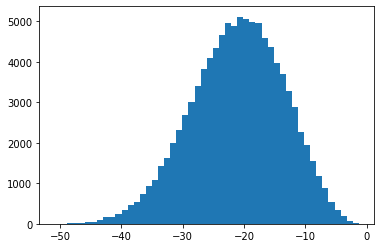

In [3]:
from inv import model

b = model.noise_sigma_bijector()

noise_sigmas = b.forward(randn(100000))

noise_power_dbs = 20*np.log10(noise_sigmas)

hist(noise_power_dbs, bins=50);

np.mean(noise_power_dbs), np.std(noise_power_dbs)

## Test model with random hyper priors

NP = 10
Number of data points: 558
Number of model dimensions: 211


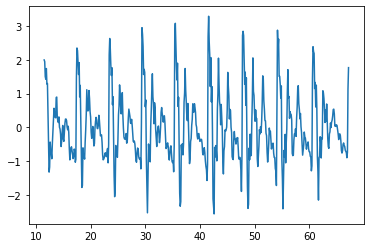

In [140]:
from inv import process

hyper = process.make_rand_hyper(
    rand_triple(), #process_data_kwargs=dict(max_NP = 3, prepend=1)
)

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

klatt.play(hyper['data']['t'], hyper['data']['d'])

In [141]:
prior = model.theta_trajectory_prior(hyper)
theta = prior.sample(seed=jaxkey())
theta, prior.log_prob(theta)

[Memory]4916.1s, 81.9min: Loading posterior_of_fitted_lf_values...
[Memory]4916.1s, 81.9min: Loading run_nested...
[Memory]4918.1s, 82.0min: Loading posterior_of_fitted_TFB_values...
[Memory]4918.2s, 82.0min: Loading run_nested...


({'noise_sigma': DeviceArray(0.10392855, dtype=float64),
  'source': DeviceArray([[1.83159018, 0.03694101, 5.94454849, 0.39973795],
               [1.82761939, 0.0357076 , 6.00682606, 0.42075039],
               [1.70396865, 0.03242129, 6.33888587, 0.37348278],
               [1.83630349, 0.03394866, 5.93910365, 0.36673569],
               [1.74803226, 0.0311858 , 6.38259688, 0.38740525],
               [1.64484254, 0.02950878, 5.91278786, 0.38836621],
               [1.93290344, 0.0306436 , 6.67290335, 0.35551319],
               [1.93738101, 0.03104787, 6.2132702 , 0.34660913],
               [1.92204353, 0.03054296, 6.40977951, 0.36814626],
               [1.81063694, 0.03109174, 5.98763601, 0.35579926]],            dtype=float64),
  'filter': DeviceArray([[ 319.8450585 ,  778.78930901, 1008.8289911 , 1199.21499675,
                1518.72031609, 2057.6389838 , 2578.61349441, 2702.007381  ,
                 783.70732509,  133.31264565,  350.16626585,  899.34736886,
                 

Show the possible model functions $f(t;\theta)$ for a sampled $\theta$. We need to find a $\theta$ for which **most** -- not just a few -- of these samples are close to the data. **This is Bayesian regularization in action.**

We can see that the general amplitude magnitude is reasonable, although for larger $K$ for PZ and $N_P$ it may take more samples to hit O(1) range. This is because of interpitch-period correlations and the heavier tails of the energy distribution of the PZ model.

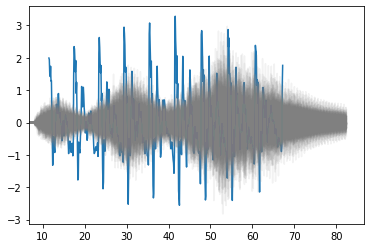

In [142]:
theta = prior.sample(seed=jaxkey())
noise_sigma, theta_source, theta_filter = model.unpack_theta(theta, hyper)

hyper2 = process.hyper_fullt(hyper)

R = model.full_kernelmatrix_root(
    theta_source, theta_filter, hyper2, convolve=True
)

plot(hyper['data']['t'], hyper['data']['d'])

nsamp = 100
for _ in range(nsamp):
    w = model.randf(hyper)
    f = R @ w
    plot(hyper['data']['fullt'], f, color='grey', alpha=1/sqrt(nsamp))

def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

setxlim(f)

klatt.play(hyper['data']['t'], f)

We can see the correlations in the $f$ amplitudes well.

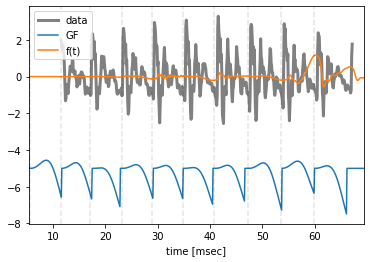

In [154]:
theta = prior.sample(seed=jaxkey())
noise_sigma, theta_source, theta_filter = model.unpack_theta(theta, hyper)
offset = model.get_offset(theta_source, hyper)

hyper2 = process.hyper_fullt(hyper)

R = model.full_kernelmatrix_root(
    theta_source, theta_filter, hyper2, convolve=True
)

R_gfd = model.full_kernelmatrix_root(
    theta_source, theta_filter, hyper2, convolve=False, integrate=True
)

w = model.randf(hyper)

plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)

plot(hyper['data']['fullt'], R_gfd @ w - 5, label="GF")
plot(hyper['data']['fullt'], R @ w, label="f(t)")
for tp in offset: axvline(tp, ls="--", color="black", alpha=.1)
xlabel("time [msec]")
setxlim(R_gfd @ w)
legend();

In [ ]:


def ns(hyper):
    theta_bijector = theta_trajectory_bijector(hyper)
    
    
    
    @jax.jit
    def logl(w):
        # SKETCH CODE NOT TESTED
        theta = theta_bijector.forward(w)
        #theta = unpack(theta, hyper)
        
        loglike = 0. #get_logl(theta)
        logprior = -theta_bijector.forward_log_det_jacobian(w) #?????
        
        return loglike + logprior
    
    ptform = scipy.special.ndtri
    
    return logl, ptform